In this datacard you will note that besides the usual SM signal contributions (ggH, qqH, ZH, and WH) there are two new processes (qqbarH_ALT and ggH_ALT) corresponding to the production of 2+m via quark-antiquark annihilation and gluon-fusion. 

In [1]:
%%bash
head jcp_hwwof_0j_8TeV.txt

imax 1 number of channels
jmax * number of background
kmax * number of nuisance parameters
Observation 5747
shapes *   *   jcp_hwwof_0j.input_8TeV.root  histo_$PROCESS histo_$PROCESS_$SYSTEMATIC
shapes data_obs * jcp_hwwof_0j.input_8TeV.root  histo_Data 
bin j0of8tev j0of8tev j0of8tev j0of8tev j0of8tev j0of8tev j0of8tev j0of8tev j0of8tev j0of8tev j0of8tev j0of8tev j0of8tev j0of8tev j0of8tev j0of8tev j0of8tev
process qqbarH_ALT ggH_ALT ZH WH qqH ggH qqWW ggWW VV Top Zjets WjetsE Wgamma Wg3l Ztt WjetsM qqWW2j
process -5 -4 -3 -2 -1 0 1 2 3 4 5 6 7 8 9 10 11
rate  129.869  146.427   1.728   5.833   3.033  234.884  3973.542  210.835  131.912  499.856   0.000  279.465  115.142  166.923  46.430  327.212   0.288


Let's look at the shape of the templates: 

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: c1


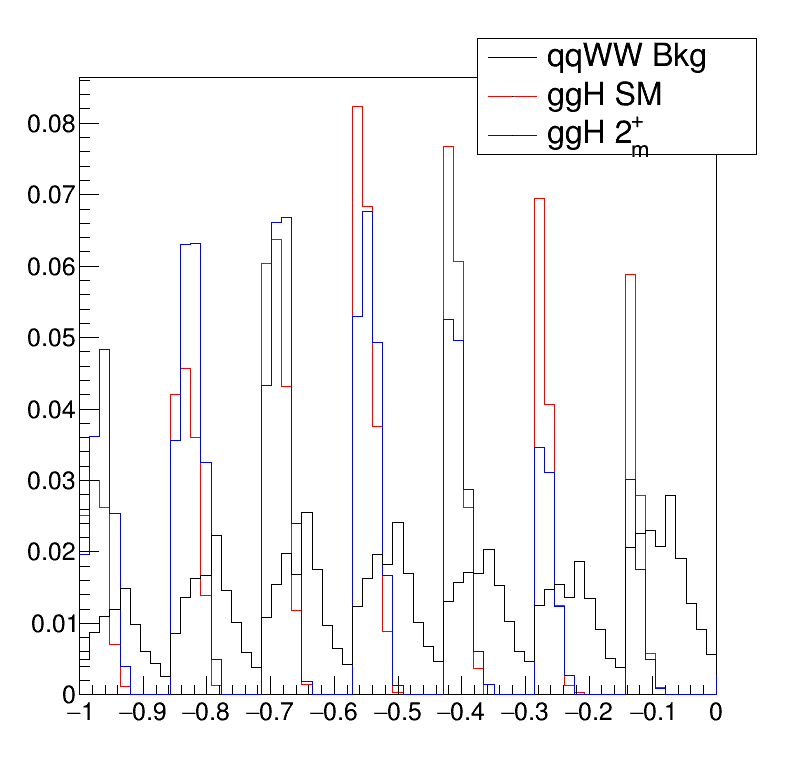

In [13]:
import ROOT as r

r.gStyle.SetOptTitle(0)
r.gStyle.SetOptStat(0)

f = r.TFile("jcp_hwwof_0j.input_8TeV.root","READ")

c1 = r.TCanvas("c1","c1",800,800)
c1.cd()

histo_ggH = f.Get("histo_ggH")
histo_ggH.SetLineColor(2)
histo_ggH.GetXaxis().SetRangeUser(-1.0,0.0)
histo_ggH.DrawNormalized("hist")

histo_ggH_ALT = f.Get("histo_ggH_ALT")
histo_ggH_ALT.SetLineColor(4)
histo_ggH_ALT.DrawNormalized("histsame")

histo_qqWW = f.Get("histo_qqWW")
histo_qqWW.SetLineColor(1)
histo_qqWW.DrawNormalized("histsame")


legend = r.TLegend(0.6,0.8,0.95,0.95)
legend.AddEntry(histo_qqWW,"qqWW Bkg")
legend.AddEntry(histo_ggH,"ggH SM")
legend.AddEntry(histo_ggH_ALT,"ggH 2_{m}^{+}")
legend.Draw("same")

c1.Draw()

You will notice multiple peaks. These correspond to an unrolled 2D histogram encoding the information of mT and mll as explained in https://twiki.cern.ch/twiki/bin/view/CMSPublic/Hig12042TWiki Basically, inside each peak mll is increasing, while different peaks correspond to larger mT values.  You can see that the signal shapes are also different, with different hypotheses having more or less signal in the different "peaks" (which correspond to different mT values).

The hypothesis test is performed by constructing a nested model which has two relevant parameters:
  *  fqq, the fraction qqbarH_ALT / (qqbarH_ALT + ggH_ALT)
  *  x, the fraction 0+ / (0+ + 2+m) 

This means that signal model is defined as S(x,fqq) = r * [ x * S(0+) + (1-x) * S(2+m) ], with S(2+m) =  fqq * S(qq->2+m) + (1-fqq)*S(gg->qq2+m). The parameter r is the usual overall signal strength which is profiled so as to not use yield information in the hypotheses test. 

You can immediately see that this general (nested) signal model encodes several interesting limiting cases: 
Hypothesis                 r    x  fqq
--------------------------------------
SMH                        1    0  -
0+                         free 0  -
gg->2+m                    free 1  0
qq->2+m                    free 1  1
production indpendent 2+m  free 1  free

 Let's create the binary workspace encoding the physics model.  The PhysicsModel that encodes the signal model above is the twoHypothesisHiggs (https://github.com/cms-analysis/HiggsAnalysis-CombinedLimit/blob/master/python/HiggsJPC.py).  We would like each of the processes to be differentiated via fqq. This is done using a "Physics Option" called "fqqIncluded". The parameter fqq is fixed to 0 by default and does not float. 

In [5]:
%%bash
text2workspace.py jcp_hwwof_0j_8TeV.txt -P HiggsAnalysis.CombinedLimit.HiggsJPC:twoHypothesisHiggs -m 125.7 --PO verbose --PO fqqIncluded -o jcp_hww.root

Will consider fqq = fraction of qqH in Alt signal (signal strength will be left floating)
MH (not there before) will be assumed to be 125.7
Process  ggH_ALT  will get scaled by  r_times_x_times_not_fqq
Process  ZH  will get scaled by  r_times_not_x
Process  qqH  will get scaled by  r_times_not_x
Process  qqbarH_ALT  will get scaled by  r_times_x_times_fqq
Process  WH  will get scaled by  r_times_not_x
Process  ggH  will get scaled by  r_times_not_x
Process  ggH_ALT  will get scaled by  r_times_x_times_not_fqq
Process  ZH  will get scaled by  r_times_not_x
Process  qqH  will get scaled by  r_times_not_x
Process  qqbarH_ALT  will get scaled by  r_times_x_times_fqq
Process  WH  will get scaled by  r_times_not_x
Process  ggH  will get scaled by  r_times_not_x


Let's now generate toys datasets to determine the test statistic distributions under different assumptions. The way the TEV test statistic works is that the POI is set to 0 and 1. In the Physics Model the POI is set to x so the two hypothesis are x=0 (SMH) and x=1 (gg->2+m, remember fqq is fixed to 0). First we do pre-fit expected:

In [6]:
%%bash
combine -M HybridNew -m 125.7 jcp_hww.root --testStat=TEV --singlePoint 1 --saveHybridResult -T 5000 --fork 8 --clsAcc 0 --fullBToys --generateExt=1 --generateNuis=0 --expectedFromGrid 0.5 -n jcp_hww_pre-fit_exp

 <<< Combine >>> 
>>> including systematics
>>> using the Ratio of Profiled Likelihoods test statistics (Q_TEV)
>>> method used is HybridNew
>>> random number generator seed is 123456
Computing results starting from observation (a-posteriori)
[#0] WARNING:Eval -- RooStatsUtils::MakeNuisancePdf - no constraints found on nuisance parameters in the input model
[#0] WARNING:Eval -- RooStatsUtils::MakeNuisancePdf - no constraints found on nuisance parameters in the input model
/tmp/rstats-sN56hu

 -- Hybrid New -- 
CLs = 0.072 +/- 0.00536656
Done in 0.00 min (cpu), 2.74 min (real)


ALERT: Tevatron test statistics not yet validated.


Second we do post-fit expected:

In [7]:
%%bash
combine -M HybridNew -m 125.7 jcp_hww.root --testStat=TEV --singlePoint 1 --saveHybridResult -T 5000 --fork 8 --clsAcc 0 --fullBToys --frequentist --expectedFromGrid 0.5 -n jcp_hww_post-fit_exp

 <<< Combine >>> 
>>> including systematics
>>> using the Ratio of Profiled Likelihoods test statistics (Q_TEV)
>>> method used is HybridNew
>>> random number generator seed is 123456
Computing results starting from observation (a-posteriori)
[#0] WARNING:Eval -- RooStatsUtils::MakeNuisancePdf - no constraints found on nuisance parameters in the input model
[#0] WARNING:Eval -- RooStatsUtils::MakeNuisancePdf - no constraints found on nuisance parameters in the input model
/tmp/rstats-juxm9N

 -- Hybrid New -- 
CLs = 0.232193 +/- 0.00967306
Done in 0.00 min (cpu), 1.94 min (real)


ALERT: Tevatron test statistics not yet validated.


Finally we do postfit observed:

In [8]:
%%bash
combine -M HybridNew -m 125.7 jcp_hww.root --testStat=TEV --singlePoint 1 --saveHybridResult -T 5000 --fork 8 --clsAcc 0 --fullBToys --frequentist -n jcp_hww_post-fit_obs

 <<< Combine >>> 
>>> including systematics
>>> using the Ratio of Profiled Likelihoods test statistics (Q_TEV)
>>> method used is HybridNew
>>> random number generator seed is 123456
Computing results starting from observation (a-posteriori)
[#0] WARNING:Eval -- RooStatsUtils::MakeNuisancePdf - no constraints found on nuisance parameters in the input model
[#0] WARNING:Eval -- RooStatsUtils::MakeNuisancePdf - no constraints found on nuisance parameters in the input model
/tmp/rstats-Vs5EiM

 -- Hybrid New -- 
CLs = 0.168814 +/- 0.010758
Done in 0.00 min (cpu), 2.00 min (real)


ALERT: Tevatron test statistics not yet validated.


First you will notice that the pre-fit expected and post fit expected cls values are different.  The difference between the post-fit expected and the pre-fit expected is related to fact that the data does not accommodate a large signal. We can check this also by performing fits for the signal strength for the two hypotheses: we create a workspace that has the signal strength as an additional parameter of interest, and then run fits for the signal strength r at a fixed value of the mixing x corresponding to the two hypotheses:

In [9]:
%%bash
combine jcp_hww.root -M MultiDimFit -m 125.7 --redefineSignalPOIs r -P r --floatOtherPOI=0 --setParameters x=0 --freezeParameters x -n MU_SCALAR
combine jcp_hww.root -M MultiDimFit -m 125.7 --redefineSignalPOIs r -P r --floatOtherPOI=0 --setParameters x=1 --freezeParameters x -n MU_SPIN2

 <<< Combine >>> 
>>> including systematics
>>> method used is MultiDimFit
>>> random number generator seed is 123456
Set Default Value of Parameter x To : 0
Computing results starting from observation (a-posteriori)

 --- MultiDimFit ---
best fit parameter values: 
   r :    +0.673
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> including systematics
>>> method used is MultiDimFit
>>> random number generator seed is 123456
Set Default Value of Parameter x To : 1
Computing results starting from observation (a-posteriori)

 --- MultiDimFit ---
best fit parameter values: 
   r :    +0.988
Done in 0.00 min (cpu), 0.00 min (real)


This implies that our post-fit expectation for the signal yield is less than the SM Higgs prediction, especially for the spin 0 case, and consequently also our post-fit expectation for the separation between the two hypotheses is worse (with less events, it's harder to separate them).

Lets look at the output of the post fit observed file. First convert the results to a tree:

In [10]:
%%bash
root -l -q -b higgsCombinejcp_hww_post-fit_obs.HybridNew.mH125.7.root ${CMSSW_BASE}/src/HiggsAnalysis/CombinedLimit/test/plotting/hypoTestResultTree.cxx\(\"jcp_hww_post-fit_obs.qvals.root\",125.7,1,\"x\"\)


Attaching file higgsCombinejcp_hww_post-fit_obs.HybridNew.mH125.7.root as _file0...
(TFile *) 0x2fdb7f0
Processing /home/cms.zdemirag/CombineTutorial/CMSSW_8_1_0/src/HiggsAnalysis/CombinedLimit/test/plotting/hypoTestResultTree.cxx("jcp_hww_post-fit_obs.qvals.root",125.7,1,"x")...
 - HypoTestResult_mh125.7_x1_1618127706
Saved test statistics distributions for 5000 signal toys and 5000 background toys to jcp_hww_post-fit_obs.qvals.root.


The type encodes which hypothesis the value of q corresponds to (observation has type zero, null is type -1 and alt is type 1). Now lets make a plot of the test statistic distributions in the observed case:

0.20343002677
These Numbers Are just approximate and hard coded for this particular example!!!
Use CLs from the combine printout for a precise value!
p null 0.382382788715
p alt 0.0685714285714
cls 0.179326660601


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: c1


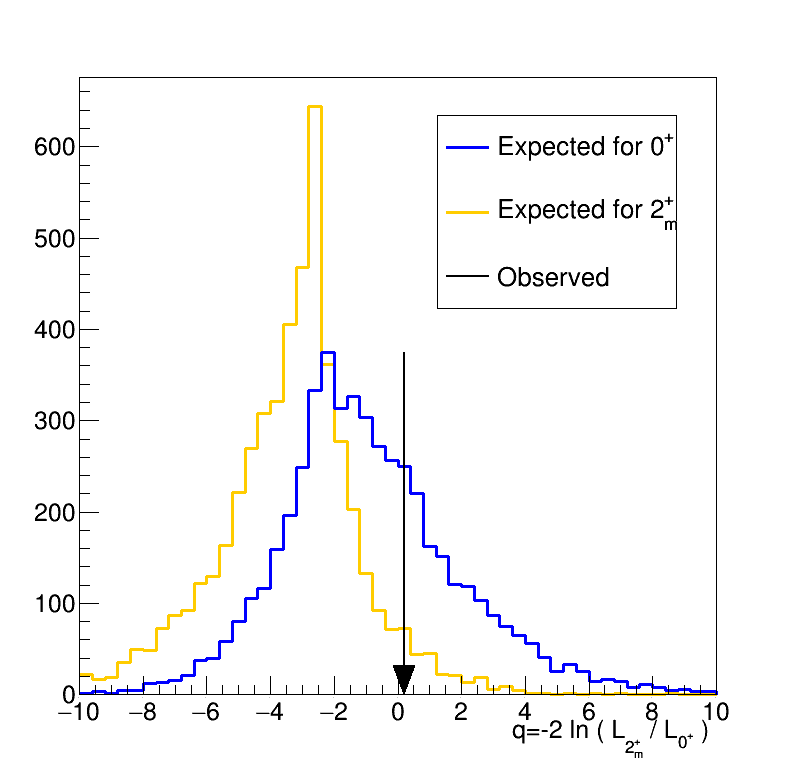

In [12]:
import ROOT as r

r.gStyle.SetOptStat(0)
r.gStyle.SetOptTitle(0)

f = r.TFile("jcp_hww_post-fit_obs.qvals.root","READ")
q = f.Get("q")


hnull = r.TH1F("hnull","hnull",50,-10,10)
halt = r.TH1F("halt","halt",50,-10,10)

#hobs = r.TH1F("hobs","hobs",50,-10,10)

q.Draw("-2*q>>hnull","type<0","goff")
q.Draw("-2*q>>halt", "type>0","goff")

q.Draw("-2*q>>hobs", "type==0","goff")
qObs = r.gROOT.FindObject("hobs").GetMean();
qO = r.TArrow(qObs, hnull.GetMaximum(), qObs, 1, 0.05, "---|>");
qO.SetAngle(40)
qO.SetLineWidth(2)

print qObs
print "These Numbers Are just approximate and hard coded for this particular example!!!"
print "Use CLs from the combine printout for a precise value!"
print "p null",hnull.Integral(25,50)/hnull.Integral()
print "p alt",halt.Integral(25,50)/halt.Integral()
print "cls",(halt.Integral(25,50)/halt.Integral())/(hnull.Integral(25,50)/hnull.Integral())

c1 = r.TCanvas("c1","c1",800,800)
c1.cd()

hnull.SetLineColor(r.kBlue)
halt.SetLineColor(r.kOrange)
halt.GetXaxis().SetTitle("q=-2 ln ( L_{2^{+}_{m}} / L_{0^{+}} ) ")

halt.Draw()
hnull.Draw("same")
#hobs.Draw("same")
qO.Draw()
hnull.Draw("AxisSame")


legend = r.TLegend(0.55,0.6,0.85,0.85)
legend.AddEntry(hnull,"Expected for 0^{+}","l")
legend.AddEntry(halt,"Expected for 2^{+}_{m}","l")
legend.AddEntry(qO,"Observed","l")
legend.Draw("same")

c1.Draw()